In [86]:
import random
from torch.utils.data import Dataset
import os
import torch
import numpy as np
import pickle
from torchvision import transforms
import lmdb
from PIL import Image
import torchvision
import cv2
from einops import rearrange, repeat
import time
import torch.nn.functional as F
import unicodedata
import re
import matplotlib.pyplot as plt

# ---------------------------------------
# Global Switch for Arabic
# ---------------------------------------
SHOW_HARAKAT = False  # or True if you want diacritics

# ---------------------------------------
# Arabic / Unifont Setup
# ---------------------------------------
# For an Arabic scenario:
arabic_chars   = "ءاأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة"
arabic_numbers = "٠١٢٣٤٥٦٧٨٩"
english_numbers= "0123456789"
punctuation    = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~،؛؟"
symbols        = "$€£¥¢©®±×÷"

# Combined letters (for content mapping)
letters = arabic_chars + arabic_numbers + english_numbers + punctuation + symbols

style_len = 416 #target width in pixels for style images (around avg. width of images in the dataset)

# =======================================
# Dataset File Paths and Generation Types
# =======================================
text_path = {
    'train': 'data/train.txt',
    'val': 'data/val.txt',
    'test': 'data/test.txt'
}

generate_type = {
    'iv_s': ['train', 'data/in_vocab.subset.tro.37'],
    'iv_u': ['test',  'data/in_vocab.subset.tro.37'],
    'oov_s': ['train', 'data/oov.common_words'],
    'oov_u': ['test',  'data/oov.common_words']
}

# ---------------------------------------
# Arabic Helper Functions
# ---------------------------------------

def preprocess_text(text):
    """
    Pre-process the text so that any contiguous sequence of English digits
    is reversed. This ensures that after the overall reversal for RTL display,
    the English numbers appear in their original order.
    """
    def reverse_digits(match):
        return match.group(0)[::-1]
    return re.sub(r'\d+', reverse_digits, text)

def effective_length(text):
    """
    Computes the effective length of a text, ignoring any harakāt (diacritics).
    The text is first normalized to NFD so that diacritics are decomposed.
    Then, any character that is a Unicode combining mark is filtered out.
    """
    decomposed = unicodedata.normalize("NFD", text)
    return len([ch for ch in decomposed if not unicodedata.combining(ch)])

def shape_arabic_text(text, letter2index):
    """
    Processes the input text as follows:
      1. Pre-processes English digit sequences
      2. Normalizes the entire text to NFC
      3. Tokenizes the text into (char, diacritic) pairs for Arabic letters,
         keeping non-Arabic characters unchanged
      4. If SHOW_HARAKAT is False, forces each Arabic letter's diacritic to "base"
      5. Determines the appropriate contextual form (isolated, initial, medial, final)
      6. Returns two lists: glyph indices + forms, reversed for RTL display.
    """
    text = preprocess_text(text)
    text = unicodedata.normalize("NFC", text)
    
    non_joining = set("اأإآدذرزو")
    harakat_set = set("ًٌٍَُِّْ")
    
    tokens = []
    i = 0
    n = len(text)
    while i < n:
        char = text[i]
        if char in arabic_chars:
            diacritic = "base"
            if i + 1 < n and text[i+1] in harakat_set:
                diacritic = unicodedata.normalize("NFC", text[i+1])
                i += 2
            else:
                i += 1
            tokens.append((char, diacritic))
        elif text[i] in harakat_set:
            i += 1
        else:
            tokens.append((text[i], None))
            i += 1
    
    # If SHOW_HARAKAT = False, forcibly set diacritic to "base"
    if not SHOW_HARAKAT:
        tokens = [(ch, "base") if ch in arabic_chars else (ch, d) for (ch, d) in tokens]
    
    indices = []
    forms_detected = []
    num_tokens = len(tokens)

    for ii, (char, d) in enumerate(tokens):
        if char in arabic_chars:
            prev_join = (ii > 0 and tokens[ii-1][0] in arabic_chars and tokens[ii-1][0] not in non_joining)
            next_join = (ii < num_tokens - 1 and tokens[ii+1][0] in arabic_chars)
            curr_joinable = (char not in non_joining)
            
            if not curr_joinable:
                form = "final" if prev_join else "isolated"
            else:
                if prev_join and next_join:
                    form = "medial"
                elif prev_join and not next_join:
                    form = "final"
                elif not prev_join and next_join:
                    form = "initial"
                else:
                    form = "isolated"

            try:
                idx = letter2index[char][form][d]
            except KeyError:
                idx = letter2index[char]["isolated"]["base"]
            indices.append(idx)
            forms_detected.append(form)
        else:
            # Non-Arabic
            if char in letter2index:
                if isinstance(letter2index[char], dict):
                    idx = letter2index[char].get("default", 0)
                else:
                    idx = letter2index[char]
                form = "default"
            else:
                idx = letter2index["PAD"]
                form = "PAD"
            indices.append(idx)
            forms_detected.append(form)
    
    # Reverse for RTL
    return list(reversed(indices)), list(reversed(forms_detected))

def strip_harakat(text):
    """
    Removes all diacritics (harakāt) from the input text.
    This function first normalizes the text to NFD (decomposed form) and then
    filters out any combining characters.
    """
    decomposed = unicodedata.normalize("NFD", text)
    stripped = "".join([ch for ch in decomposed if not unicodedata.combining(ch)])
    return stripped


def plot_glyphs(glyphs, word, labels):
    """
    Plots glyph images horizontally. The first glyph is actually the last char in word.
    """
    num_chars = glyphs.shape[0]
    fig, axes = plt.subplots(1, num_chars, figsize=(num_chars * 2, 2))
    rev_word = word[::-1]  # so label matches the reversed glyph
    for i, ax in enumerate(axes):
        ax.imshow(glyphs[i].numpy(), cmap='gray')
        ax.set_title(f"{rev_word[i]}\n{labels[i]}", fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# =======================================
# IAMDataset for Training/Inferences
# =======================================
class IAMDataset(Dataset):
    def __init__(self, 
                 image_path,
                 style_path,
                 laplace_path,
                 type,
                 content_type='unifont_arabic',
                 max_len=10):
        
        self.max_len = max_len
        self.style_len = style_len
        
        # read lines from e.g. data/train.txt
        data_file = text_path[type]
        self.data_dict = self.load_data(data_file)

        # Now join the 'type' folder to each of the paths.
        self.image_path   = os.path.join(image_path, type)
        self.style_path   = os.path.join(style_path, type)
        self.laplace_path = os.path.join(laplace_path, type)
        
        # these are used for the content (Arabic)
        self.letters = letters
        self.tokens = {"PAD_TOKEN": len(self.letters)}
        self.letter2index = {label: n for n, label in enumerate(self.letters)}
        self.indices = list(self.data_dict.keys())

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5),
                                             (0.5, 0.5, 0.5))
        ])

        # load unifont_arabic or unifont, etc.
        self.con_symbols, _ = self.get_symbols(content_type)

        # example placeholder for a Laplace filter
        self.laplace = torch.tensor([[0, 1, 0],
                                     [1,-4, 1],
                                     [0, 1, 0]], dtype=torch.float32
                                   ).to(torch.float32).view(1, 1, 3, 3).contiguous()

    def get_symbols(self, input_type):
        """
        Load Arabic symbols from data/{input_type}.pickle
        Returns con_symbols + letter2index
        """
        with open(f"data/{input_type}.pickle", "rb") as f:
            data = pickle.load(f)
        glyph_entries = data['with_harakat']['glyph_entries']
        letter2index = data['with_harakat']['letter2index']

        max_idx = max(e['idx'][0] for e in glyph_entries)
        glyph_list = [None]*(max_idx+1)

        for entry in glyph_entries:
            idx_val = entry['idx'][0]
            mat_16x16 = entry['mat'].astype(np.float32)
            glyph_list[idx_val] = torch.from_numpy(mat_16x16)
        con_symbols = torch.stack(glyph_list)

        return con_symbols, letter2index

    def load_data(self, data_path):
        """
        Expects lines like:
           alexuw-648,648-1.jpg شأن
        Then s_id='alexuw-648', image='648-1.jpg', transcription='شأن'
        If SHOW_HARAKAT is False, diacritics are stripped from transcription.
        Lines with transcription length > self.max_len are skipped.
        """
        with open(data_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        full_dict = {}
        idx = 0
        for line in lines:
            parts = line.strip().split(' ', 1)  # e.g. ["alexuw-648,648-1.jpg", "شأن"]
            if len(parts) < 2:
                continue
            first_field, transcription = parts[0], parts[1]
            first_parts = first_field.split(',')
            if len(first_parts) < 2:
                continue
            s_id = first_parts[0]     # e.g. "alexuw-648"
            image = first_parts[1]    # e.g. "648-1.jpg"

            # If harakat are turned off, strip them from the ground truth transcription.
            if not SHOW_HARAKAT:
                transcription = strip_harakat(transcription)

            if effective_length(transcription) > self.max_len:
                continue

            full_dict[idx] = {
                'image': image,
                's_id': s_id,        # string, e.g. "alexuw-648"
                'label': transcription
            }
            idx += 1
        return full_dict

    def get_style_ref(self, wr_id):
        """
        Writer ID might be "ifnenit-cj11". But style images are named "cj11_028.tif", etc.
        So we parse the suffix after the dash.
        E.g. wr_id.split('-',1)[1] => "cj11".
        Then we find files in style_path that start with that suffix. 
        We pick 2 random among them, load them (and the corresponding laplace images),
        and if their heights differ, we force the second image to match the first image's height.
        Finally, we build and return new_style_images and new_laplace_images.
        """
        import cv2
        
        # 1) Parse the suffix after the dash (if any)
        parts = wr_id.split('-', 1)
        if len(parts) > 1:
            suffix = parts[1]
        else:
            suffix = wr_id  # If no dash present, use the entire wr_id

        # 2) Collect all style filenames that start with suffix
        style_list = [f for f in os.listdir(self.style_path) if f.startswith(suffix)]
        if len(style_list) < 2:
            raise RuntimeError(f"Not enough style images found for writer suffix {suffix} in {self.style_path}")

        # 3) Pick two random files from style_list
        style_index = random.sample(range(len(style_list)), 2)  # anchor + positive

        # 4) Read the chosen files (style + laplace), storing them in lists
        style_images = [
            cv2.imread(os.path.join(self.style_path, style_list[idx]), flags=0)
            for idx in style_index
        ]
        laplace_images = [
            cv2.imread(os.path.join(self.laplace_path, style_list[idx]), flags=0)
            for idx in style_index
        ]

        # 5) If heights are inconsistent, resize the second image (and its laplace)
        h0 = style_images[0].shape[0]
        h1 = style_images[1].shape[0]
        if h0 != h1:
            import cv2  # ensure cv2 is imported
            scale = h0 / float(h1)
            new_w = int(style_images[1].shape[1] * scale)
            style_images[1] = cv2.resize(style_images[1], (new_w, h0), interpolation=cv2.INTER_LINEAR)
            laplace_images[1] = cv2.resize(laplace_images[1], (new_w, h0), interpolation=cv2.INTER_LINEAR)

            
        # 6) Now heights are consistent; compute max width
        height = style_images[0].shape[0]
        max_w = max(img.shape[1] for img in style_images)

        # 7) Convert images to float32 [0,1]
        style_images   = [img.astype(np.float32) / 255.0 for img in style_images]
        laplace_images = [img.astype(np.float32) / 255.0 for img in laplace_images]

        # 8) Build final arrays with shape [2, height, max_w]
        new_style_images = np.ones((2, height, max_w), dtype=np.float32)
        new_style_images[0, :, :style_images[0].shape[1]] = style_images[0]
        new_style_images[1, :, :style_images[1].shape[1]] = style_images[1]

        new_laplace_images = np.zeros((2, height, max_w), dtype=np.float32)
        new_laplace_images[0, :, :laplace_images[0].shape[1]] = laplace_images[0]
        new_laplace_images[1, :, :laplace_images[1].shape[1]] = laplace_images[1]

        return new_style_images, new_laplace_images

    
    def __len__(self):
        return len(self.indices)
    
    ### Borrowed from GANwriting ###
    def label_padding(self, labels, max_len):
        ll = [self.letter2index[i] for i in labels]
        num = max_len - len(ll)
        if not num == 0:
            ll.extend([self.tokens["PAD_TOKEN"]] * num)  # replace PAD_TOKEN
        return ll

    def __getitem__(self, idx):
        sample = self.data_dict[self.indices[idx]]
        image_name = sample['image']    
        label = sample['label']         
        wr_id = sample['s_id']          

        # Now the image is in self.image_path (flat structure)
        img_path = os.path.join(self.image_path, image_name)
        image = Image.open(img_path).convert('RGB')
        image = self.transforms(image)

        # dummy style
        style_ref, laplace_ref = self.get_style_ref(wr_id)
        style_ref = torch.from_numpy(style_ref).float()
        laplace_ref = torch.from_numpy(laplace_ref).float()

        # store wr_id as a string, no int() casting
        return {
            'img': image,          # [3,H,W]
            'content': label,      # e.g. "شأن"
            'style': style_ref,    # [2, h, w]
            'laplace': laplace_ref,# [2, h, w]
            'wid': wr_id,          # store as string (e.g. "alexuw-648")
            'transcr': label,
            'image_name': image_name
        }

    def collate_fn_(self, batch):
        width = [item['img'].shape[2] for item in batch]
        c_width = [len(item['content']) for item in batch]
        s_width = [item['style'].shape[2] for item in batch]

        transcr = [item['transcr'] for item in batch]
        target_lengths = torch.IntTensor([len(t) for t in transcr])
        image_name = [item['image_name'] for item in batch]

        max_s_width = max(s_width) if max(s_width) < self.style_len else self.style_len

        B = len(batch)

        imgs = torch.ones(
            [B,
             batch[0]['img'].shape[0],
             batch[0]['img'].shape[1],
             max(width)], dtype=torch.float32
        )
        content_ref = torch.zeros([B, max(c_width), 16, 16], dtype=torch.float32)
        
        style_ref = torch.ones([B,
                                batch[0]['style'].shape[0],
                                batch[0]['style'].shape[1],
                                max_s_width], dtype=torch.float32)
        
        laplace_ref = torch.zeros([B,
                                   batch[0]['laplace'].shape[0],
                                   batch[0]['laplace'].shape[1],
                                   max_s_width], dtype=torch.float32)
        
        target = torch.zeros([B, max(target_lengths)], dtype=torch.int32)

        for i, item in enumerate(batch):
            w_cur = item['img'].shape[2]
            imgs[i, :, :, :w_cur] = item['img']

            # fill content
            content_inds = [self.letter2index[ch] for ch in item['content']]
            glyphs = self.con_symbols[content_inds]
            content_ref[i, :len(glyphs)] = glyphs

            # fill target
            target[i, :len(transcr[i])] = torch.tensor(
                [self.letter2index[ch] for ch in transcr[i]], dtype=torch.int32
            )

            # fill style
            cur_style_w = item['style'].shape[2]
            if max_s_width < self.style_len:
                style_ref[i, :, :, :cur_style_w] = item['style']
                laplace_ref[i, :, :, :cur_style_w] = item['laplace']
            else:
                style_ref[i, :, :, :cur_style_w] = item['style'][:, :, :self.style_len]
                laplace_ref[i, :, :, :cur_style_w] = item['laplace'][:, :, :self.style_len]

        # Instead of converting wid to tensor, we keep them in a list
        writer_ids = [item['wid'] for item in batch]

        content_ref = 1.0 - content_ref

        return {
            'img': imgs,
            'style': style_ref,
            'content': content_ref,
            'wid': writer_ids,   # List of strings
            'laplace': laplace_ref,
            'target': target,
            'target_lengths': target_lengths,
            'image_name': image_name
        }

# ---------------------------------------
# Random_StyleIAMDataset
# ---------------------------------------

class Random_StyleIAMDataset(IAMDataset):
    def __init__(self, style_path, laplace_path, ref_num, text_file) -> None:
        """
        style_path: a single flat folder containing style images
        laplace_path: single flat folder containing matching laplace images
        ref_num: how many times we want to sample references
        text_file: the path to e.g. 'data/train.txt' or 'data/test.txt' that includes writer IDs

        We'll parse that file to gather a set of writer IDs.
        """
        self.style_path = style_path
        self.laplace_path = laplace_path
        self.style_len = style_len
        self.ref_num = ref_num

        # Collect author IDs from the text file, e.g. "alexuw-648" from lines like:
        #   alexuw-648,648-1.jpg نفق
        self.author_id = self._get_all_writer_ids(text_file)

    def _get_all_writer_ids(self, text_file):
        """
        Reads the lines from text_file, extracts wr_id from each line 
        (the part before the comma), e.g. "alexuw-648",
        stores them in a set to avoid duplicates, then returns a list.
        """
        wr_set = set()
        with open(text_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        for line in lines:
            parts = line.strip().split(' ', 1)
            if len(parts) < 2:
                continue
            first_field = parts[0]  # e.g. "alexuw-648,648-1.jpg"
            ff = first_field.split(',')
            if len(ff) < 2:
                continue
            wr_id = ff[0]  # e.g. "alexuw-648"
            wr_set.add(wr_id)
        return list(wr_set)

    def __len__(self):
        return self.ref_num

    def parse_suffix(self, wr_id):
        """
        e.g.: "alexuw-648" -> "648", "ifnenit-cj11" -> "cj11"
        If there's no dash, we keep the entire wr_id as suffix.
        """
        parts = wr_id.split('-', 1)
        if len(parts) > 1:
            return parts[1]
        else:
            return wr_id

    def get_style_ref(self, wr_id): # Choose the style image whose length exceeds 58 pixels
        """
        - Parse suffix
        - style_list = all files in self.style_path that start with that suffix
        - random.shuffle => pick the first whose width > 58
        - read style, laplace => scale => return
        """
        suffix = self.parse_suffix(wr_id)

        # gather all style files that start with suffix
        style_list = [f for f in os.listdir(self.style_path) if f.startswith(suffix)]
        random.shuffle(style_list)

        style_image = None
        laplace_image = None
        
        for style_ref in style_list:
            
            s_img_path = os.path.join(self.style_path, style_ref)
            l_img_path = os.path.join(self.laplace_path, style_ref)

            s_img = cv2.imread(s_img_path, flags=0)
            l_img = cv2.imread(l_img_path, flags=0)
            if s_img is None or l_img is None:
                # skip if file not found or read error
                continue

            # your snippet: "if style_image.shape[1] > 58: break"
            if s_img.shape[1] > 58:
                style_image = s_img.astype(np.float32) / 255.0
                laplace_image = l_img.astype(np.float32) / 255.0
                break
            else:
                continue

        if style_image is None or laplace_image is None:
            raise RuntimeError(f"No style image with width>58 found for suffix='{suffix}' (writer '{wr_id}') in {self.style_path}.")

        return style_image, laplace_image

    def __getitem__(self, _):
        """
        We mimic your snippet: 
          - iterate over self.author_id
          - get style/laplace
          - store them, build final Tensors
        """
        batch = []
        for idx in self.author_id:
            style_img, laplace_img = self.get_style_ref(idx)

            style_t = torch.from_numpy(style_img).unsqueeze(0).to(torch.float32)
            laplace_t = torch.from_numpy(laplace_img).unsqueeze(0).to(torch.float32)
            # shape is [1, H, W]

            wid = idx
            batch.append({
                'style': style_t,
                'laplace': laplace_t,
                'wid': wid
            })

        # Now replicate final logic to unify them
        s_width = [item['style'].shape[2] for item in batch]
        if max(s_width) < self.style_len:
            max_s_width = max(s_width)
        else:
            max_s_width = self.style_len

        # shape: [len(batch), 1, H, max_s_width]
        style_ref = torch.ones([
            len(batch),
            batch[0]['style'].shape[0],
            batch[0]['style'].shape[1],
            max_s_width
        ], dtype=torch.float32)
        laplace_ref = torch.zeros([
            len(batch),
            batch[0]['laplace'].shape[0],
            batch[0]['laplace'].shape[1],
            max_s_width
        ], dtype=torch.float32)

        wid_list = []
        for i, item in enumerate(batch):
            cur_w = item['style'].shape[2]
            try:
                if max_s_width < self.style_len:
                    style_ref[i, :, :, :cur_w] = item['style']
                    laplace_ref[i, :, :, :cur_w] = item['laplace']
                else:
                    style_ref[i, :, :, :cur_w]   = item['style'][:, :, :self.style_len]
                    laplace_ref[i, :, :, :cur_w] = item['laplace'][:, :, :self.style_len]
                
                wid_list.append(item['wid'])
            except:
                print('style', item['style'].shape)

        return {
            'style': style_ref,
            'laplace': laplace_ref,
            'wid': wid_list
        }
        
# =======================================
# Prepare the Content Image During Inference
# =======================================
class ContentData(IAMDataset):
    """
    Minimal for text->glyph. Ignores images entirely, so we override __init__ to skip image logic.
    """
    def __init__(self, content_type='unifont_arabic'):
        # letters used for fallback
        self.letters = letters
        self.letter2index = {label: n for n, label in enumerate(self.letters)}
        # load the con_symbols from pickle
        self.con_symbols, self.letter2index = self.get_symbols(content_type)

    def get_content(self, text):
        # shape the text
        indices, _ = shape_arabic_text(text, self.letter2index)
        indices_tensor = torch.tensor(indices, dtype=torch.long)
        glyphs = self.con_symbols[indices_tensor]
        glyphs = 1.0 - glyphs
        return glyphs.unsqueeze(0)  # [1, len(text), 16,16]

    # overrides IAMDataset's get_symbols to skip path logic
    def get_symbols(self, input_type):
        with open(f"data/{input_type}.pickle", "rb") as f:
            data = pickle.load(f)
        glyph_entries = data['with_harakat']['glyph_entries']
        letter2index = data['with_harakat']['letter2index']

        max_idx = max(e['idx'][0] for e in glyph_entries)
        glyph_list = [None]*(max_idx+1)

        for entry in glyph_entries:
            idx_val = entry['idx'][0]
            mat_16x16 = entry['mat'].astype(np.float32)
            glyph_list[idx_val] = torch.from_numpy(mat_16x16)
        con_symbols = torch.stack(glyph_list)
        return con_symbols, letter2index


content_tensor shape: torch.Size([1, 9, 16, 16])


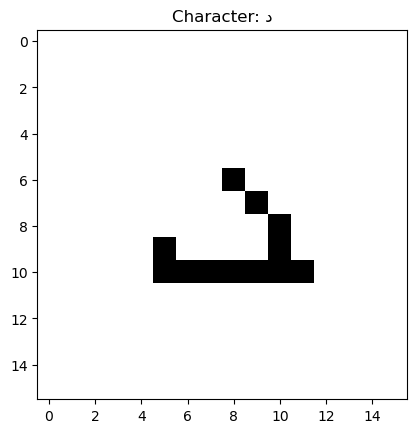

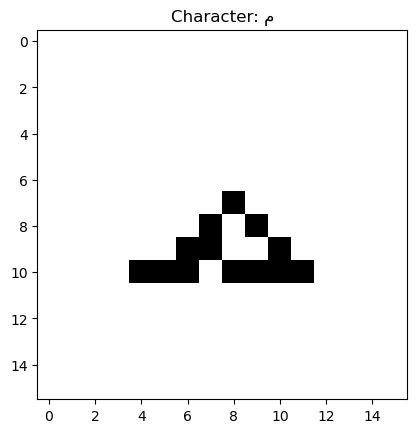

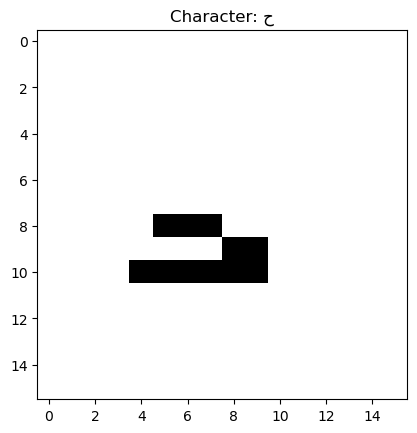

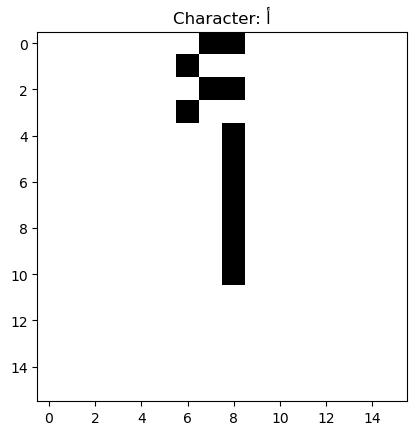

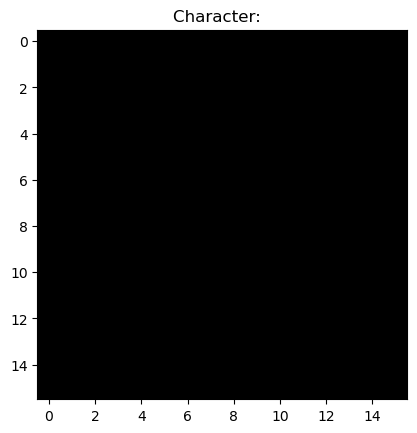

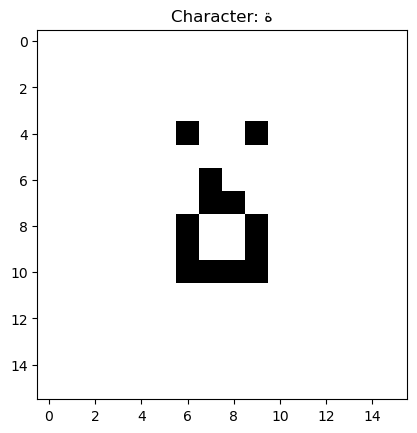

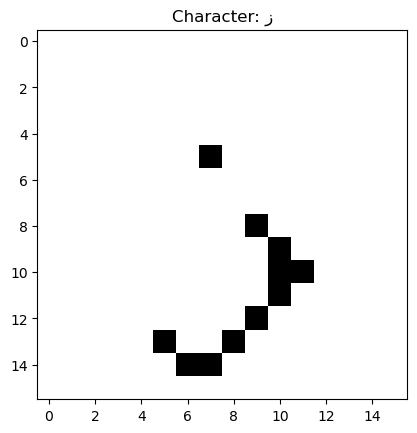

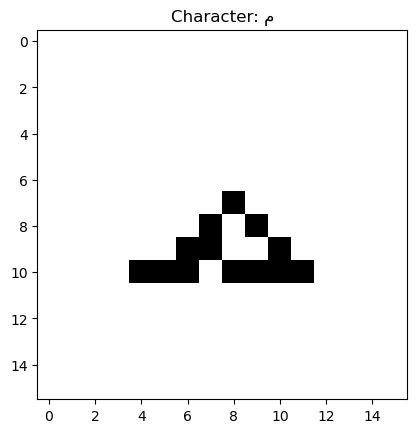

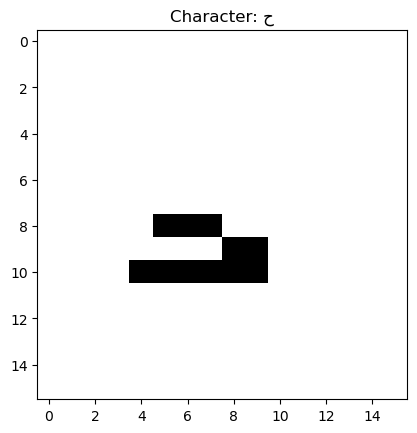

In [87]:
if __name__ == "__main__":
    content_data = ContentData("unifont_arabic")
    example_text = "حمزة أحمد"
    content_tensor = content_data.get_content(example_text)
    print("content_tensor shape:", content_tensor.shape)
    
    # Plot each glyph
    # The first glyph in content_tensor is the *last* character in example_text
    reversed_text = example_text[::-1]
    
    import matplotlib.pyplot as plt
    for i in range(content_tensor.shape[1]):
        glyph = content_tensor[0, i].cpu().numpy()
        plt.figure()
        plt.imshow(glyph, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Character: {reversed_text[i]}")
        plt.show()


Final dataset length after skipping is 41380.
Dataset[1251] => text=الخزانات
Writer ID (string)=ifnenit-bq66  |  image_name=bq66_047.tif


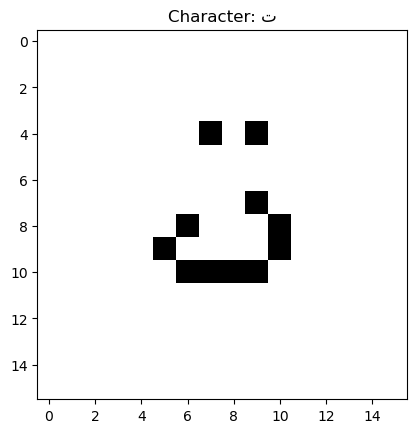

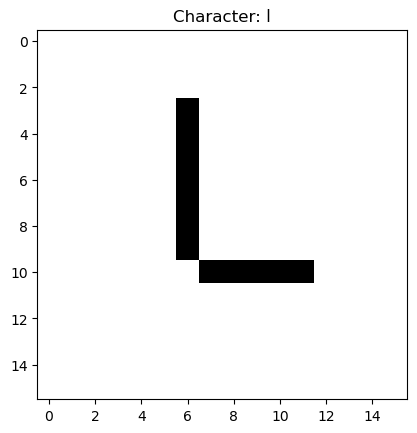

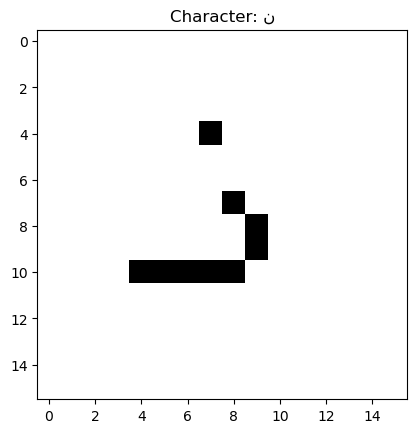

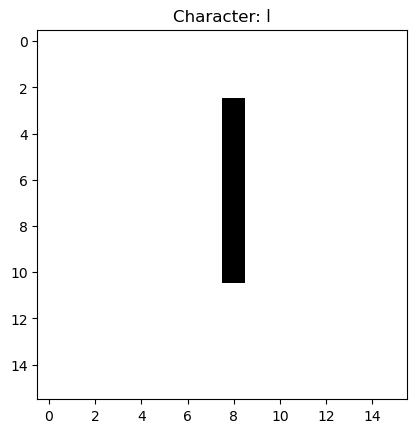

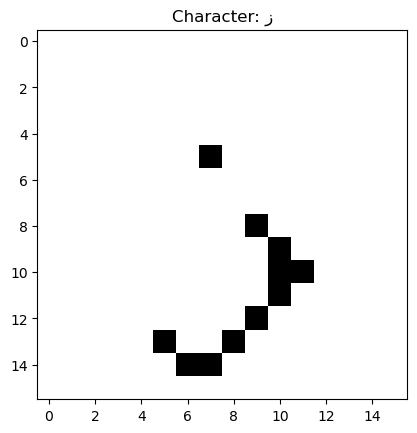

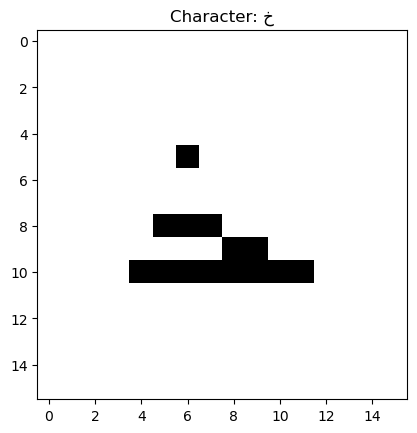

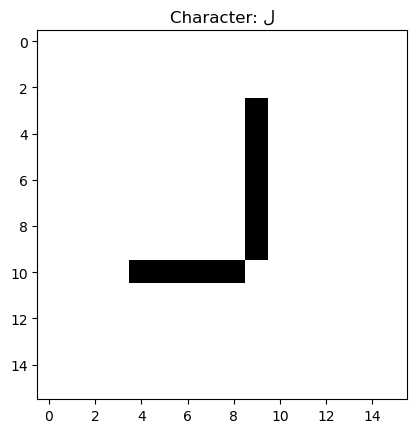

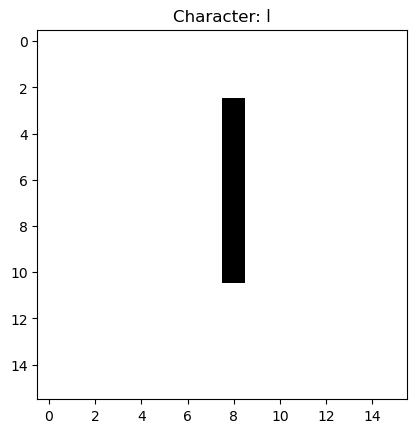

In [88]:
if __name__ == "__main__":
    # The user-chosen index
    i = 1251
    max_len = 10  # same as used in your dataset

    # ----------------------------------------------------------
    # 1) Check if line i was "skip-worthy" in the raw text file
    # ----------------------------------------------------------
    train_txt = text_path['train']  # e.g., "data/train.txt"
    with open(train_txt, "r", encoding="utf-8") as f:
        lines = f.readlines()

    if i >= len(lines):
        print(f"Line {i} doesn't exist in {train_txt} (only {len(lines)} lines).")
    else:
        raw_line = lines[i].rstrip("\n")
        parts = raw_line.split(" ", 1)
        if len(parts) < 2:
            print(f"[Line {i}] would be skipped (no transcription part). Raw: {raw_line}")
        else:
            first_field, transcription = parts[0], parts[1]
            ff_parts = first_field.split(",")
            if len(ff_parts) < 2:
                print(f"[Line {i}] would be skipped (invalid image info). Raw: {raw_line}")
            else:
                elen = effective_length(transcription)
                if elen > max_len:
                    print(f"[Line {i}] would be skipped: length={elen} > max_len={max_len}. Raw: {raw_line}")
                else:
                    pass

    # ----------------------------------------------------------
    # 2) Build the dataset with the correct path
    # ----------------------------------------------------------
    # Use 'data/combined_dataset' so that final image path is:
    # data/combined_dataset/train/<writerID>/<imageName>

    dataset = IAMDataset(
        image_path='data/combined_dataset',  # for images: data/combined_dataset/train/<writerId>/<image>
        style_path='data/combined_dataset',  # point to the EXACT folder that has cj11_006.tif
        laplace_path='data/combined_dataset_laplace',
        type='train',
        content_type='unifont_arabic',
        max_len=10
    )

    ds_len = len(dataset)
    print(f"Final dataset length after skipping is {ds_len}.")

    # ----------------------------------------------------------
    # 3) Attempt to show dataset[i]
    # ----------------------------------------------------------
    if i < ds_len:
        sample = dataset[i]
        example_text = sample['content']
        print(f"Dataset[{i}] => text={example_text}")
        print(f"Writer ID (string)={sample['wid']}  |  image_name={sample['image_name']}")

        content_data = ContentData("unifont_arabic")
        content_tensor = content_data.get_content(example_text)
        reversed_text = example_text[::-1]
        for g_i in range(content_tensor.shape[1]):
            glyph = content_tensor[0, g_i].cpu().numpy()
            plt.figure()
            plt.imshow(glyph, cmap='gray', vmin=0, vmax=1)
            plt.title(f"Character: {reversed_text[g_i]}")
            plt.show()
    else:
        print(f"Dataset index {i} is out of range (length={ds_len}). Possibly line {i} was skipped.")
        fallback = i + 1
        if fallback < ds_len:
            print(f"Plotting the next available item => dataset[{fallback}]")
            sample = dataset[fallback]
            example_text = sample['content']
            print(f"Next text: {example_text}  (writer={sample['wid']}, image={sample['image_name']})")

            content_data = ContentData("unifont_arabic")
            content_tensor = content_data.get_content(example_text)
            reversed_text = example_text[::-1]
            for g_i in range(content_tensor.shape[1]):
                glyph = content_tensor[0, g_i].cpu().numpy()
                plt.figure()
                plt.imshow(glyph, cmap='gray', vmin=0, vmax=1)
                plt.title(f"Character: {reversed_text[g_i]}")
                plt.show()
        else:
            print("No fallback available (the dataset is that short).")
